# Feature selection with filter methods


In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from scripts.tracks import get_tracks

pd.set_option('display.max_columns', None)

#### Unpickle FE dataframe

In [2]:
data = pd.read_pickle('/home/alepfu/Desktop/dataset/pickle/event000001000_FE.pkl')
data.shape

(103305, 54)

#### Pick a sample of tracks

In [3]:
N_tracks = 500
data = get_tracks(data, N_tracks=N_tracks, drop_zero_weights=False, drop_zero_id=False, factorize_particle_id=False)
print(data.shape)

(4803, 54)


#### Set features for use in feature selection
We can only make use of information from the hit level and the engineered features.

In [4]:
data = data[['hit_id','particle_id','x','y','z','volume_id','layer_id','module_id',
             'x_scaled','y_scaled','z_scaled','r_cyl','theta','theta_atan2','r_sph','phi','phi_atan2',
             'x_r_cyl','y_r_cyl','z_r_cyl','x_r_sph','y_r_sph','z_r_sph',
             'n_pixel','signal_pixel','phi_pixel','theta_pixel','path_pixel','u_pixel','v_pixel',
             'vol_inner','vol_short','vol_long','vol_lay_mul','vol_lay_add','vol_lay_concat',
             'z_dir','cos_dist_rc','cos_dist_lc']]

print(data.shape)

(4803, 39)


## Filter Methods

Filter methods apply statistical measures for scoring each feature. The methods are usually univariate and look at the features independently, approaches include:

* Pearson correlation
* Chi^2 
* Mutual Information
* F-test statistics

Since Chi^2 needs positive input values, we skip it. A comparison of F-test and MI approaches can be found [here](http://scikit-learn.org/stable/auto_examples/feature_selection/plot_f_test_vs_mi.html#sphx-glr-auto-examples-feature-selection-plot-f-test-vs-mi-py).

### Pearson Correlation
We start with simpliy calculating the correlation of each feature with the particle ID, then investigate high and low scoring features.

In [5]:
corr = data.corr()
corr = corr['particle_id']
corr.sort_values(ascending=False)[1:8]

z_r_cyl        0.821680
z_r_sph        0.806684
cos_dist_lc    0.806684
phi_atan2      0.795641
z_dir          0.731448
z_scaled       0.693711
z              0.693711
Name: particle_id, dtype: float64

In [6]:
corr.sort_values(ascending=True)[:7]

phi           -0.837393
cos_dist_rc   -0.806684
vol_inner     -0.104779
layer_id      -0.099327
r_sph         -0.017183
n_pixel       -0.008271
theta         -0.000660
Name: particle_id, dtype: float64

### Mutual Information
Mutual information measures the information that X and Y share. It measures how much knowing one of these variables reduces uncertainty about the other. Mutual information methods can capture any kind of statistical dependency, but being nonparametric, they require more samples for accurate estimation.

In [7]:
%%time

X = data.loc[:, data.columns != 'particle_id']
y = data[['particle_id']].values.ravel()

mi = mutual_info_classif(X, y)
mi /= mi.max()

CPU times: user 13.4 s, sys: 24 ms, total: 13.5 s
Wall time: 13.5 s


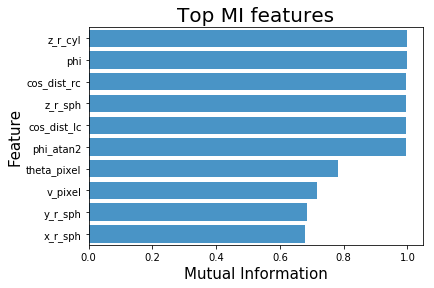

In [8]:
mi_frame = pd.DataFrame(list(zip(X.columns.values, mi)), columns=['feature', 'mi'])
ax = sns.barplot(x='mi', y='feature', data=mi_frame.sort_values('mi', ascending=False).head(10), color='#3498db');
ax.set_title('Top MI features', fontsize=20);
ax.set_xlabel('Mutual Information', fontsize=15);
ax.set_ylabel('Feature',fontsize=15);

### F-statistic

F-test estimates the degree of linear dependency between two random variables.

In [9]:
%%time
X = data.loc[:, data.columns != 'particle_id']
y = data[['particle_id']].values.ravel()

f_selector = SelectKBest(f_classif, k=5)
f_selector.fit_transform(X, y)
f_scores = f_selector.scores_
f_scores /= f_scores.max()

CPU times: user 92 ms, sys: 0 ns, total: 92 ms
Wall time: 92.9 ms


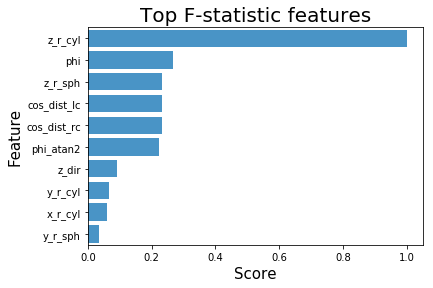

In [10]:
scores_df = pd.DataFrame(list(zip(X.columns.values, f_scores)), columns=['feature', 'f_value'])
scores_df = scores_df.sort_values('f_value', ascending=False)

ax = sns.barplot(x="f_value", y="feature", data=scores_df.head(10), color='#3498db');
ax.set_title('Top F-statistic features', fontsize=20);
ax.set_xlabel('Score', fontsize=15);
ax.set_ylabel('Feature',fontsize=15);